### Imports:

In [104]:
import numpy as np
import datetime as dt
import time
import matplotlib.pyplot as plt
from pandas import Series, DataFrame, read_json, to_datetime

### Exemplos "originais" (via Telegram):

In [105]:
dados = read_json('https://api.binance.com/api/v3/klines?symbol=BTCUSDT&interval=15m&limit=340')
dados2 = read_json('https://api.binance.com/api/v3/klines?symbol=VETUSDT&interval=15m&startTime=1628125200000&endTime=1628989200000&limit=1000')

### Exemplos interativos:

In [106]:
symbol = 'BTCUSDT'
interval='15m'
limit='340'

dados3 = read_json('https://api.binance.com/api/v3/klines?symbol={}&interval={}&limit={}'.format(
   symbol, interval, limit)
)

dados3.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1634277600000,59550.00,59641.00,59399.13,59500.00,558.14345,1634278499999,3.321862e+07,20261,303.54110,1.806554e+07,0
1,1634278500000,59499.99,59597.68,59358.00,59450.00,683.34763,1634279399999,4.061985e+07,21950,385.38636,2.290850e+07,0
2,1634279400000,59450.01,59558.31,59402.05,59494.38,463.75002,1634280299999,2.759014e+07,18750,229.36065,1.364521e+07,0
3,1634280300000,59494.38,59720.00,59465.29,59653.15,619.48487,1634281199999,3.692271e+07,20968,351.97742,2.097964e+07,0
4,1634281200000,59653.15,59689.99,59442.95,59470.31,405.28025,1634282099999,2.413346e+07,13256,206.95968,1.232333e+07,0


58945.34
62557.59
0.05774279348037545


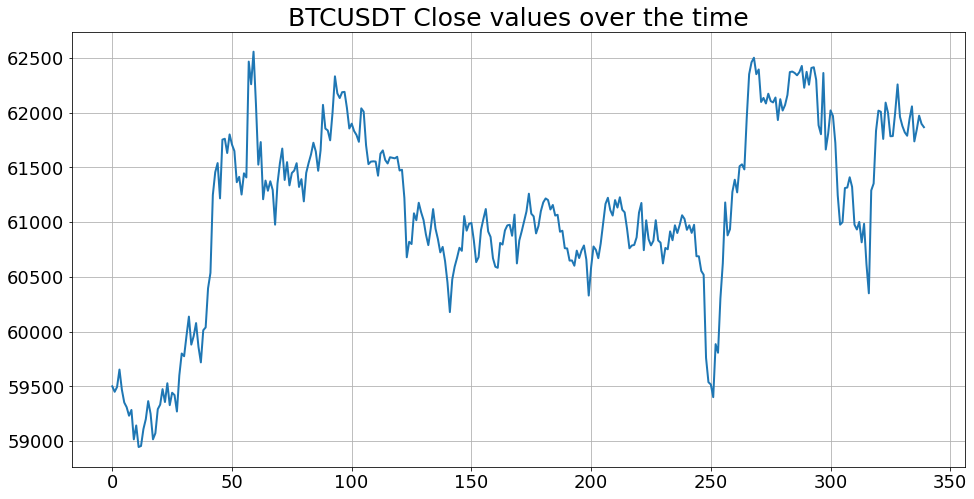

In [107]:
fig = dados3[4].plot(figsize = (16,8), grid=True, fontsize = 18, linewidth=2.0)
plt.title(f'{symbol} Close values over the time', fontdict = {'fontsize' : 25})


print(dados3[4].min())
print(dados3[4].max())

print((dados3[4].max() - dados3[4].min())/(dados3[4].max()))


In [119]:
symbol = 'VETUSDT'
interval='15m'
limit='1000'

data_inicio = '2021-08-04'
horario_inicio = '22:00'

data_fim = '2021-08-14'
horario_fim = '22:00'

startTime = int(dt.datetime.fromisoformat(data_inicio+'T'+horario_inicio).timestamp()) * 1000
endTime = int(dt.datetime.fromisoformat(data_fim+'T'+horario_fim).timestamp()) * 1000

dados4 = read_json('https://api.binance.com/api/v3/klines?symbol={}&interval={}&startTime={}&endTime={}&limit={}'.format(
   symbol, interval, startTime, endTime, limit)
)

dados4.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1628125200000,0.08766,0.08781,0.08715,0.08750,8970288.9,1628126099999,784309.393265,1862,4190426.2,366426.641583,0
1,1628126100000,0.08749,0.08794,0.08715,0.08739,5273980.2,1628126999999,461475.225651,881,2096332.3,183510.766137,0
2,1628127000000,0.08740,0.08789,0.08740,0.08770,2742793.3,1628127899999,240564.612551,652,1184607.7,103880.676020,0
3,1628127900000,0.08769,0.08849,0.08743,0.08841,5081190.2,1628128799999,447512.057374,933,3331613.9,293561.271792,0
4,1628128800000,0.08841,0.08920,0.08828,0.08913,6231756.1,1628129699999,553489.299184,1587,3777593.6,335479.304425,0


### Coletando dados de 15 em 15 minutos para um range largo de datas e exportando resultados:

In [72]:
symbol = 'VETUSDT'
interval='15m'
limit='1000'

data_inicio = '2021-09-01'
horario_inicio = '22:00'

data_fim = '2021-10-15'
horario_fim = '22:00'

delta = dt.timedelta(days=10)
data_atual = dt.datetime.fromisoformat(data_inicio+'T'+horario_inicio)

dados_list = [ [], [], [], [], [], [] ]

while(data_atual < dt.datetime.fromisoformat(data_fim+'T'+horario_fim)):
    print('Data Atual:', data_atual)
    
    startTime = int(data_atual.timestamp()) * 1000
    endTime = int( (data_atual + delta).timestamp()) * 1000

    dados_atual = read_json('https://api.binance.com/api/v3/klines?symbol={}&interval={}&startTime={}&endTime={}&limit={}'.format(
        symbol, interval, startTime, endTime, limit)
    )

    dados_list[0].extend(dados_atual[0].apply(lambda x : dt.datetime.fromtimestamp(x/1000)).tolist())
    dados_list[1].extend(dados_atual[0])
    dados_list[2].extend(dados_atual[1])
    dados_list[3].extend(dados_atual[2])
    dados_list[4].extend(dados_atual[3])
    dados_list[5].extend(dados_atual[4])

    data_atual += delta
        
print('Gerando arquivo .csv...')        

dados_completo = DataFrame(dados_list).T
dados_completo.columns = ['Date-Time', 'Timestamp', 'Open', 'Max', 'Min', 'Close']
dados_completo.set_index('Date-Time', inplace=True)

dados_completo.to_csv('dados_VETUSDT_15m.csv')

print('Procedimento realizado com sucesso!')

Data Atual: 2021-09-01 22:00:00
Data Atual: 2021-09-11 22:00:00
Data Atual: 2021-09-21 22:00:00
Data Atual: 2021-10-01 22:00:00
Data Atual: 2021-10-11 22:00:00
Gerando arquivo .csv...
Procedimento realizado com sucesso!


### Percorrendo os indices do tipo datetime usando .loc[]:

In [7]:
dados[12] = to_datetime(dados[0].apply(lambda x : dt.datetime.fromtimestamp(x/1000)))
dados.set_index(12, inplace=True)

In [8]:
dados.loc['2021-10-15 01:00:00':'2021-10-16 04:20:37']

,0,1,2,3,4,5,6,7,8,9,10,11
12,,,,,,,,,,,,
2021-10-15 01:00:00,1634270400000,59431.70,59490.00,59142.86,59167.71,983.017478,1634271299999,5.833616e+07,25278,468.516388,2.781086e+07,0
2021-10-15 01:15:00,1634271300000,59167.71,59669.00,59161.79,59528.33,1280.415982,1634272199999,7.611992e+07,39799,749.708917,4.459223e+07,0
2021-10-15 01:30:00,1634272200000,59528.34,59630.10,59366.94,59630.10,776.046220,1634273099999,4.617894e+07,20687,411.820700,2.450644e+07,0
2021-10-15 01:45:00,1634273100000,59630.10,59700.00,59482.80,59597.64,925.947859,1634273999999,5.523269e+07,22984,556.294659,3.319024e+07,0
2021-10-15 02:00:00,1634274000000,59597.64,59823.69,59554.50,59755.03,1148.237920,1634274899999,6.856902e+07,31944,801.191697,4.784284e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-16 03:15:00,1634364900000,62187.48,62319.77,62000.00,62190.55,415.790870,1634365799999,2.582850e+07,15428,225.892260,1.403383e+07,0
2021-10-16 03:30:00,1634365800000,62190.54,62209.79,62035.58,62044.09,227.034210,1634366699999,1.409849e+07,12002,119.791570,7.438431e+06,0
2021-10-16 03:45:00,1634366700000,62044.08,62100.00,61856.00,61856.00,318.632810,1634367599999,1.974443e+07,13903,176.060790,1.091085e+07,0


### Coletando dados de 1 em 1 minuto para um range largo de datas e exportando resultados:

In [73]:
symbol = 'VETUSDT'
interval='1m'
limit='1000'

data_inicio = '2021-10-01'
horario_inicio = '22:00'

data_fim = '2021-10-15'
horario_fim = '22:00'

delta = dt.timedelta(hours=16)
data_atual = dt.datetime.fromisoformat(data_inicio+'T'+horario_inicio)

dados_list = [ [], [], [], [], [], [] ]

while(data_atual < dt.datetime.fromisoformat(data_fim+'T'+horario_fim)):
    print('Data Atual:', data_atual)
    
    startTime = int(data_atual.timestamp()) * 1000
    endTime = int( (data_atual + delta).timestamp()) * 1000

    dados_atual = read_json('https://api.binance.com/api/v3/klines?symbol={}&interval={}&startTime={}&endTime={}&limit={}'.format(
        symbol, interval, startTime, endTime, limit)
    )

    dados_list[0].extend(dados_atual[0].apply(lambda x : dt.datetime.fromtimestamp(x/1000)).tolist())
    dados_list[1].extend(dados_atual[0])
    dados_list[2].extend(dados_atual[1])
    dados_list[3].extend(dados_atual[2])
    dados_list[4].extend(dados_atual[3])
    dados_list[5].extend(dados_atual[4])

    data_atual += delta
        
print('Gerando arquivo .csv...')        

dados_completo = DataFrame(dados_list).T
dados_completo.columns = ['Date-Time', 'Timestamp', 'Open', 'Max', 'Min', 'Close']
dados_completo.set_index('Date-Time', inplace=True)

dados_completo.to_csv('dados_VETUSDT_1m.csv')

print('Procedimento realizado com sucesso!')

Data Atual: 2021-10-01 22:00:00
Data Atual: 2021-10-02 14:00:00
Data Atual: 2021-10-03 06:00:00
Data Atual: 2021-10-03 22:00:00
Data Atual: 2021-10-04 14:00:00
Data Atual: 2021-10-05 06:00:00
Data Atual: 2021-10-05 22:00:00
Data Atual: 2021-10-06 14:00:00
Data Atual: 2021-10-07 06:00:00
Data Atual: 2021-10-07 22:00:00
Data Atual: 2021-10-08 14:00:00
Data Atual: 2021-10-09 06:00:00
Data Atual: 2021-10-09 22:00:00
Data Atual: 2021-10-10 14:00:00
Data Atual: 2021-10-11 06:00:00
Data Atual: 2021-10-11 22:00:00
Data Atual: 2021-10-12 14:00:00
Data Atual: 2021-10-13 06:00:00
Data Atual: 2021-10-13 22:00:00
Data Atual: 2021-10-14 14:00:00
Data Atual: 2021-10-15 06:00:00
Gerando arquivo .csv...
Procedimento realizado com sucesso!


In [111]:
def gerar_csv_dados_cripto(symbol, interval, limit, data_inicio=None, horario_inicio=None, data_fim=None, horario_fim=None, log=True):
    if(interval == '1m'):
        delta = dt.timedelta(hours=16)
    elif(interval == '3m'):
        delta = dt.timedelta(days=2)
    elif(interval == '5m'):
        delta = dt.timedelta(days=3)
    elif(interval == '15m'):
        delta = dt.timedelta(days=10)
    elif(interval == '30m'):
        delta = dt.timedelta(days=20)
    elif(interval == '1h'):
        delta = dt.timedelta(days=40)
    elif(interval == '2h'):
        delta = dt.timedelta(days=80)
    elif(interval == '4h'):
        delta = dt.timedelta(days=160)
    elif(interval == '6h'):
        delta = dt.timedelta(days=240)
    elif(interval == '8h'):
        delta = dt.timedelta(days=320)
    elif(interval == '12h'):
        delta = dt.timedelta(days=480)
    elif(interval == '1d'):
        delta = dt.timedelta(days=1000)
    elif(interval == '3d'):
        delta = dt.timedelta(days=3000)
    elif(interval == '1w'):
        delta = dt.timedelta(weeks=1000)
    elif(interval == '1M'):
        delta = dt.timedelta(weeks=4000)
    else:
        raise ValueError('intervalError')
        
    if(horario_inicio == None):
        horario_inicio = '00:00:00'
    if(horario_fim == None):
        #horario_fim = dt.datetime.now()
        #horario_fim = str(horario_fim.hour)+':'+str(horario_fim.minute)+':'+str(horario_fim.second)
        horario_fim = '23:59:59'
        
    if(limit > 1000):
        limit = 1000
    if(limit <= 0):
        raise ValueError('limitError')
        
    if(data_inicio == None):
        path_dados = 'https://api.binance.com/api/v3/klines?symbol={}&interval={}&limit={}'.format(
            symbol, interval, limit
        )
        dados_atual = read_json(path_dados).iloc[:, :5]
        dados_atual.insert(loc=0, column='Date-Time', value = dados_atual[0].apply(lambda x : dt.datetime.fromtimestamp(x/1000)))
        
        print('Gerando arquivo .csv...')

        dados_atual.columns = ['Date-Time', 'Timestamp', 'Open', 'Max', 'Min', 'Close']
        dados_atual.set_index('Date-Time', inplace=True)

        dados_atual.to_csv(f'dados_{symbol}_{interval}.csv')

        print('Procedimento realizado com sucesso!')
    
        return
    elif((data_inicio != None) and (data_fim != None)):
        path_dados_base = 'https://api.binance.com/api/v3/klines?symbol={}&interval={}&startTime={}&endTime={}&limit={}'
        limit = 1000
    else:
        data_fim = dt.datetime.now()
        data_fim = str(data_fim.year)+'-'+str(data_fim.month)+'-'+str(data_fim.day)
        
        path_dados_base = 'https://api.binance.com/api/v3/klines?symbol={}&interval={}&startTime={}&endTime={}&limit={}'
        
        limit = 1000

    data_atual = dt.datetime.fromisoformat(data_inicio+'T'+horario_inicio)

    dados_list = [ [], [], [], [], [], [] ]
    
    primeiro_laco = True

    momento_final = dt.datetime.fromisoformat(data_fim+'T'+horario_fim)
    momento_final_timestamp = int(dt.datetime.timestamp(momento_final)) * 1000
    
    it_count = 1
    
    while(data_atual < momento_final):
        if(log):
            print('Iteracao Atual:', it_count)
            print('Data Atual:', data_atual)

        startTime = int(data_atual.timestamp()) * 1000
        aux_endTime = int( (data_atual + delta).timestamp()) * 1000
        if(aux_endTime < momento_final_timestamp):
            endTime = aux_endTime
        else:
            endTime = momento_final_timestamp

        dados_atual = read_json(path_dados_base.format(symbol, interval, startTime, endTime, limit))
        
        if(primeiro_laco):
            dados_list[0].extend([dt.datetime.fromtimestamp(dados_atual[0][0]/1000)])
            dados_list[1].extend([dados_atual[0][0]])
            dados_list[2].extend([dados_atual[1][0]])
            dados_list[3].extend([dados_atual[2][0]])
            dados_list[4].extend([dados_atual[3][0]])
            dados_list[5].extend([dados_atual[4][0]])
            
        dados_list[0].extend(dados_atual[0][1:].apply(lambda x : dt.datetime.fromtimestamp(x/1000)).tolist())
        dados_list[1].extend(dados_atual[0][1:])
        dados_list[2].extend(dados_atual[1][1:])
        dados_list[3].extend(dados_atual[2][1:])
        dados_list[4].extend(dados_atual[3][1:])
        dados_list[5].extend(dados_atual[4][1:])

        data_atual += delta
        it_count += 1
        
        primeiro_laco = False

    print('Gerando arquivo .csv...')        

    dados_completo = DataFrame(dados_list).T
    dados_completo.columns = ['Date-Time', 'Timestamp', 'Open', 'Max', 'Min', 'Close']
    dados_completo.set_index('Date-Time', inplace=True)

    dados_completo.to_csv(f'dados_{symbol}_{interval}.csv')

    print('Procedimento realizado com sucesso!')
    
    return

In [122]:
gerar_csv_dados_cripto(symbol='VETUSDT', interval='15m', limit=1000, data_inicio='2019-01-01')

Iteracao Atual: 1
Data Atual: 2019-01-01 00:00:00
Iteracao Atual: 2
Data Atual: 2019-01-11 00:00:00
Iteracao Atual: 3
Data Atual: 2019-01-21 00:00:00
Iteracao Atual: 4
Data Atual: 2019-01-31 00:00:00
Iteracao Atual: 5
Data Atual: 2019-02-10 00:00:00
Iteracao Atual: 6
Data Atual: 2019-02-20 00:00:00
Iteracao Atual: 7
Data Atual: 2019-03-02 00:00:00
Iteracao Atual: 8
Data Atual: 2019-03-12 00:00:00
Iteracao Atual: 9
Data Atual: 2019-03-22 00:00:00
Iteracao Atual: 10
Data Atual: 2019-04-01 00:00:00
Iteracao Atual: 11
Data Atual: 2019-04-11 00:00:00
Iteracao Atual: 12
Data Atual: 2019-04-21 00:00:00
Iteracao Atual: 13
Data Atual: 2019-05-01 00:00:00
Iteracao Atual: 14
Data Atual: 2019-05-11 00:00:00
Iteracao Atual: 15
Data Atual: 2019-05-21 00:00:00
Iteracao Atual: 16
Data Atual: 2019-05-31 00:00:00
Iteracao Atual: 17
Data Atual: 2019-06-10 00:00:00
Iteracao Atual: 18
Data Atual: 2019-06-20 00:00:00
Iteracao Atual: 19
Data Atual: 2019-06-30 00:00:00
Iteracao Atual: 20
Data Atual: 2019-07-1

In [100]:
dados[0].apply(lambda x: dt.datetime.fromtimestamp(x/1000))

0     2021-10-14 21:45:00
1     2021-10-14 22:00:00
2     2021-10-14 22:15:00
3     2021-10-14 22:30:00
4     2021-10-14 22:45:00
              ...        
335   2021-10-18 09:30:00
336   2021-10-18 09:45:00
337   2021-10-18 10:00:00
338   2021-10-18 10:15:00
339   2021-10-18 10:30:00
Name: 0, Length: 340, dtype: datetime64[ns]